In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [272]:
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns

import json
import lzma
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer
import string
import datetime as dt

import numpy as np  
import pandas as pd 
import re           
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/20765011/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [90]:
# defining a function to remove \n and HTML tags
# function adapted from https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    text_divided = text.splitlines()
    text_divided_clean = " ".join(text_divided)
    text_divided_clean = text_divided_clean.lower()
    # DS: I re-added this line to remove parantheses
    text_divided_clean = re.sub(r'\([^)]*\)', '', text_divided_clean)
    text_divided_clean = re.sub('"','', text_divided_clean) # remove '"'
    text_divided_clean = re.sub(r"'s\b","",text_divided_clean) # remove ''s'
    
    #NOTE: This below line removes all punctuation...so we are only
    #training at the word-level, not sentence level
    text_divided_clean = re.sub("[^a-zA-Z]", " ", text_divided_clean) # removes all strings that contains a non-letter
    tokens = [w for w in text_divided_clean.split() if not w in stop_words] 
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word (number of letters < 3)
            long_words.append(i)   
    return (" ".join(long_words)).strip()


# setting up tokenizer
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [133]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [152]:
remove = string.punctuation
remove = remove.replace(".", "")
remove

'!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'

In [206]:
#Summary cleaner code MUST have punctuation and should NOT get rid of 
# short words like "the" or "and". 
# Code borrowed from: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
def summary_cleaner(text):
    newString = re.sub('"','', text)
    
    #added line to remove parantheses
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r"'s\b","",newString)
    #newString = re.sub("[^a-zA-Z]", " ", newString)
    
    #Keep periods, remove other punctuation
    # borrowed from: https://stackoverflow.com/questions/21209024/python-regex-remove-all-punctuation-except-hyphen-for-unicode-string
    #remove = string.punctuation
    #remove = remove.replace(".", "") # don't remove period or commas
    remove = '][;()!"#$%&*+-'
    pattern = r"[{}]".format(remove) # create the pattern
    newString = re.sub(pattern,"",newString)
    
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [207]:
summary_cleaner(headnotes[1])

'case no. 4,170. dunlop et al. v. west. brunner, col. cas. 27 hayw. n. c. 346. circuit court, d. north carolina. 1805. reported by albert brunner, esq., and here reprinted by permission. '

In [16]:
cases = []
with lzma.open("./NC_text/data/data.jsonl.xz", 'r') as jsonl_file:
    for case in jsonl_file:
        cases.append(json.loads(str(case, 'utf-8')))

df = pd.DataFrame(cases)

In [68]:
headnotes = []
opinions = []

for c in cases:
    head = c['casebody']['data']['head_matter']
    op = c['casebody']['data']['opinions']
    
    #Do not append empty headnotes or empty opinion text
    if head and op:
        headnotes.append(head)
        opinions.append(op)

In [71]:
text_ops = []
for op in opinions:
    text_ops.append(op[0]['text'])

In [210]:
'_START_ ' + summary_cleaner(headnotes[1]) + ' _END_'

'_START_ case no. 4,170. dunlop et al. v. west. brunner, col. cas. 27 hayw. n. c. 346. circuit court, d. north carolina. 1805. reported by albert brunner, esq., and here reprinted by permission.  _END_'

In [211]:
%%time
clean_opinions = []
clean_headnotes = []

for op in text_ops:
    clean_opinions.append(text_cleaner(op))
    
for note in headnotes:
    clean_headnotes.append('_START_ ' + summary_cleaner(note)+ ' _END_')

CPU times: user 1min 48s, sys: 993 ms, total: 1min 49s
Wall time: 1min 49s


In [267]:
df_data = pd.DataFrame({'headnotes': clean_headnotes, 'text': clean_opinions})

In [215]:
op_token_count = []
head_token_count = []

for i in clean_opinions:
      op_token_count.append(len(i.split()))

for i in clean_headnotes:
      head_token_count.append(len(i.split()))
length_df = pd.DataFrame({'text':op_token_count, 'summary':head_token_count})

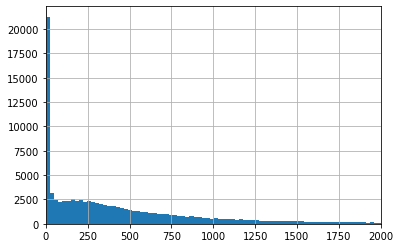

In [299]:
length_df['text'].hist(bins = 1000)
plt.xlim([0,2000])
plt.show()

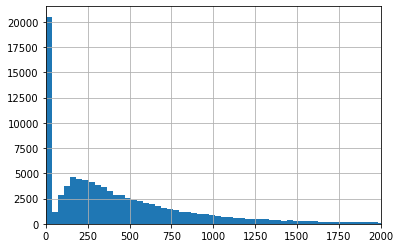

In [240]:
length_df['summary'].hist(bins = 1000)
plt.xlim([0,2000])
plt.show()

In [244]:
# total number of headnote collections betwen 50 and 1250 words
len(length_df.index[(length_df['summary'] > 50) & (length_df['summary'] < 1250)])

68827

In [271]:
# Get indices of headnotes with less than 50 words
drop_indices = length_df.index[(length_df['summary'] < 50)]

# Drop indices with super short summaries
df_data = df_data.drop(drop_indices)

In [273]:
x_train,x_test,y_train,y_test=train_test_split(df_data['text'],df_data['headnotes'],test_size=0.1,random_state=0,shuffle=True) 

In [274]:
x_tr,x_val,y_tr,y_val=train_test_split(x_train ,y_train,test_size=0.1,random_state=0,shuffle=True) 

In [307]:
%%time
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

CPU times: user 27.1 s, sys: 19.5 ms, total: 27.1 s
Wall time: 27.1 s


In [308]:
#Arbitrarily set max text length to 1000, since most texts are under 1000 words
max_len_text = 1000

In [309]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
x_tr_sequences = x_tokenizer.texts_to_sequences(x_tr)
x_val_sequences = x_tokenizer.texts_to_sequences(x_val)

x_tr_ready=pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val_ready=pad_sequences(x_val, maxlen=max_len_text, padding='post')

word_index = x_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

ValueError: invalid literal for int() with base 10: 'ublic good upon due compensation yates milwaukee material inquire whether river navigable unnavigable right defendant upper riparian proprietor acquired statutes wbicb referred must exercised due reg

In [ ]:
# Tokenize headnotes
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_text, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_text, padding='post')

word_index_y = y_tokenizer.word_index

In [279]:
# Get GloVE word embeddings
# https://nlp.stanford.edu/projects/glove/
## I used wikipedia 2014+ Gigaword
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

'm'

In [10]:
# tokenizing headnotes and opinions
df['headnotes'] = df['headnotes'].apply(lambda x: tokenizer.tokenize(x))
df['opinions'] = df['opinions'].apply(lambda x: tokenizer.tokenize(x))
